In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import h5py
from tqdm import tqdm

import DMsimulator as DMsim
import DMerror as DMerr


In [2]:

#########* Constants and fixed parameters of the model
const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}

#########* Steric factors reactions
steric_dict = {
        ###* Atomic oxygen
        "SF_O_F": 1.0, "SF_O_S": 1.0, "SF_O_SO": 1.0, "SF_O_FO": 1.0,
        "SF_FO_S": 1.0, "SF_FO_SO": 1.0, "SF_FO_FO": 1.0, "SF_FO": 1.0,
        
        ###* Molecular oxygen
        "SF_O2_F": 1.0, "SF_O2_FO": 1.0, "SF_O2_FO2": 1.0, "SF_O_FO2": 1.0,
        "SF_FO2_FO": 1.0, "SF_FO_FO2": 1.0, "SF_FO2": 1.0,
        
        ###* Metastable species
        "SF_O2fast_SO": 1.0, "SF_Ofast_SO": 1.0, "SF_O2fast_S": 1.0,  "SF_Ofast_S": 1.0,
        "SF_Ofast_Sdb": 1.0, "SF_Ofast_SOdb": 1.0, "SF_O2fast_Sdb": 1.0, "SF_O2fast_SOdb": 1.0,
        "SF_O_Sdb": 1.0, "SF_O_SOdb": 1.0, "SF_FO_SOdb": 1.0, "SF_FO_Sdb": 1.0,
}

#########* Energy barriers  --  Based Model
energy_dict = { # kJ/mol and s^-1
        "E_O_F": 0.0, "E_O_S": 0.0, "E_O_SO": 15.0, "E_O_FO": 0.0, 
        "E_FO_SO": 20.0, "E_FO_FO":0.0, "E_di_O": 15.0, "E_de_O": 30.0,
        
        "E_O2_F": 0.0, "E_O2_FO": 0.0, "E_O2_FO2": 0.0, "E_O_FO2": 0.0, 
        "E_FO2_FO": 0.0, "E_FO_FO2": 0.0, "E_di_O2": 15.0, "E_de_O2": 17.5,
        
        "E_O2fast_SO": 0.0, "E_O2fast_S": 0.0, "E_O2fast_SOdb": 0.0, "E_O2fast_Sdb": 0.0, "E_Ofast_Sdb": 0.0,
        "E_Ofast_SOdb": 0.0, "E_O_Sdb": 0.0, "E_O_SOdb": 0.0, "E_F_SOdb": 0.0, "E_FO_SOdb": 0.0,
        "ED_db": 14.999,
        
        "nu_D": 1.0e13, "nu_d": 1.0e15,
        
        "Emin": 2.90, # eV
        "Ealpha": 3400.0, # K
        
        # "Emin": 2.60, # eV
        # "Ealpha":  3.23383702e+03, # K
}

file_input_data = "Experimental_data_Paper.hdf5"

In [3]:

class MyErrorModel(DMerr.ErrorPropagation):
    
    def modify_energy_dict(self, counter):
    
        A = 2.74332762e-03
        B = 6.23703570e-04 
        E_nu_d = 1.68496853e+01
        
        Ealpha = 3.26673523e+03 
        Emin = 2.70000000e+00 
        ED_db = 1.00000000e+01
        
        Tw = self.input_data_dict[counter]['Tw']
        R = self.const_dict['R']
        
        
        nu_d = 1e15 * (A + B * np.exp(E_nu_d / (R * Tw)))
        
        self.energy_dict_base['nu_d'] = nu_d
        self.energy_dict_base['Ealpha'] = Ealpha
        self.energy_dict_base['Emin'] = Emin
        self.energy_dict_base['ED_db'] = ED_db
        
        return self.energy_dict_base



def data_error_study(std_input_ratio_dict):
    
    system = MyErrorModel(const_dict, steric_dict, energy_dict, file_input_data)
    exp_len = len(system.input_data_dict)
    
    x_mean_error = []
    x_xtd_error = []
    hist_error = []
    
    pbar = tqdm(total=exp_len)
    for counter in range(exp_len):
        
        x_mean, x_std, hist = system.func_input_error_propagation_MC(std_input_ratios_dict, counter, N=5_000)
        
        pbar.update(1)
        
        x_mean_error.append(x_mean)
        x_xtd_error.append(x_std)
        hist_error.append(hist)
    
    pbar.close()
    
    x_mean_error = np.array(x_mean_error)
    x_xtd_error = np.array(x_xtd_error)
    hist_error = np.array(hist_error)
    
    return x_mean_error, x_xtd_error, hist_error
    

In [4]:
#### plotting

def plot_error_bars(gamma_mean_error, gamma_std_error, std_energy_ratio_dict):

    print("Sensitivity study to: ", std_energy_ratio_dict.keys())
    
    Tw_unique_values = np.unique(Tw_vec)
    for value in Tw_unique_values:
        Tw = value
        indices = np.where((Tw_vec == Tw))[0]
        
        gammas_exp = gammas_exp_vec[indices]
        
        gammas_mean = gamma_mean_error[indices]
        gammas_std = gamma_std_error[indices]
        
        gammas_total_comp = gammas_data[indices]
        gammas_total = np.sum(gammas_total_comp, axis=1)
        
        Tnw = Tnw_vec[indices]
        # print("pair: ", Tnw)
        x_vec = 300*np.reciprocal(Tnw)
        
        pressure = pressure_vec[indices]
        
        fig, ax = plt.subplots()
        
        ax.errorbar(x_vec, gammas_mean*1e4, yerr=gammas_std*1e4, fmt='.', color="black", label='Ensemble')
        # ax.errorbar(x_vec, gammas_exp*1e4, yerr=gammas_exp*1e4*0.15, fmt='.', color="blue", label='Experiment')
        ax.scatter(x_vec, gammas_exp*1e4, label='Experimental', marker='s')
        ax.scatter(x_vec, gammas_total*1e4, label='Total', marker='s')
        
        
        if Tw-273.15 == -20:
            ax.set_yticks(range(0, 51, 10))
            filename = 'Tw-20UpgMod.png'
        if Tw-273.15 == 5:
            ax.set_yticks(range(0, 31, 5))
            filename = 'Tw5UpgMod.png'
        if Tw-273.15 == 25:
            ax.set_yticks(range(0, 26, 5))
            filename = 'Tw25UpgMod.png'
        if Tw-273.15 == 50:
            ax.set_yticks(range(0, 26, 5))
            filename = 'Tw50UpgMod.png'
        
        
        plt.xlabel(r"$300/T_{nw}$")
        plt.ylabel(r"$\gamma ~~ \times 10^4$")
        plt.title('Tw = %d' % (Tw-273.15))
        # plt.yscale('log')
        plt.legend()

In [5]:
with h5py.File('simulations/results_TDPaperWithLowPressureOptimizedCheck.hdf5', 'r') as f:
    
    exp_data = f['exp_data'][:]
    gammas_data = f['gammas_data'][:]
    gammas_names = f['gammas_names'][:].astype(str)
    exp_names = f['exp_names'][:].astype(str)
    recProbExp = f['recProbExp'][:]
    
    f.close()


Tnw_vec = exp_data[:, 0]
Tw_vec = exp_data[:, 1]
pressure_vec = exp_data[:, 3]
current_vec = exp_data[:, 4]
gammas_exp_vec = recProbExp

In [6]:
std_input_ratios_dict = {
    'Tnw': 0.02, # low
    'Tw': 0.01, # low
    'O_den': 0.1,
    'N_den': 0.1
}

data_mean, data_std, data_hist = data_error_study(std_input_ratios_dict)

  0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 66/66 [06:07<00:00,  5.57s/it]


Sensitivity study to:  dict_keys(['Tnw', 'Tw', 'O_den', 'N_den'])


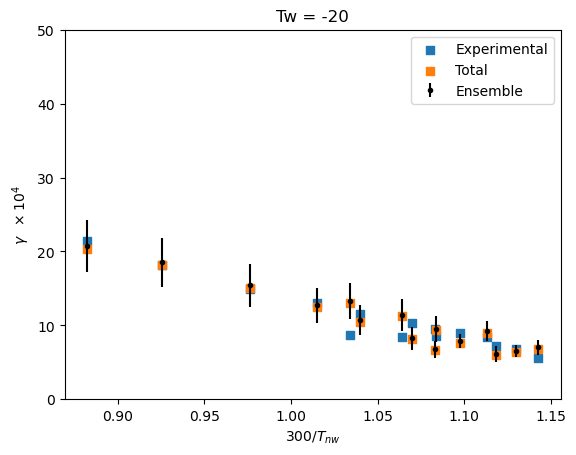

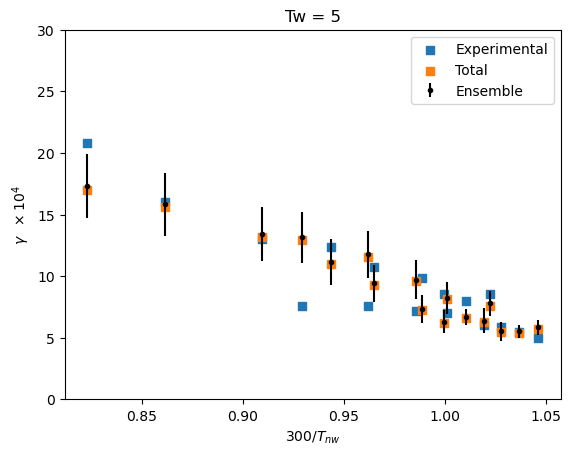

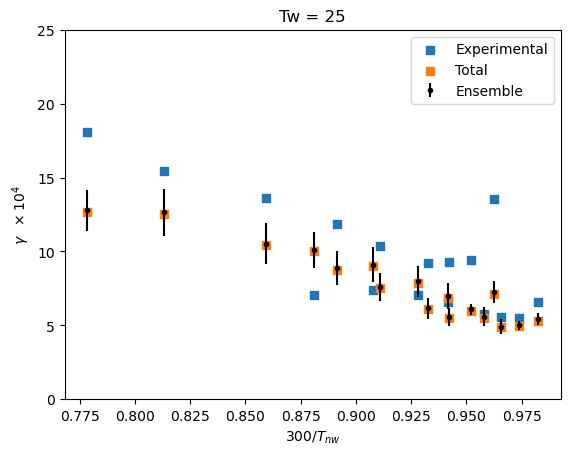

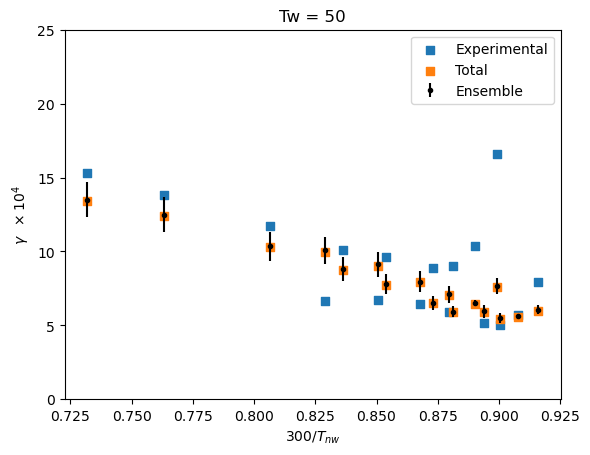

In [7]:
plot_error_bars(data_mean, data_std, std_input_ratios_dict)

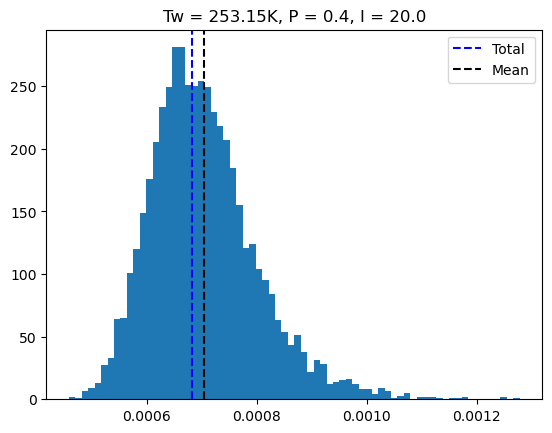

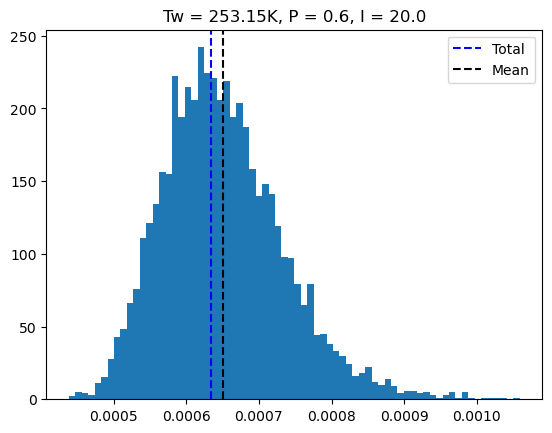

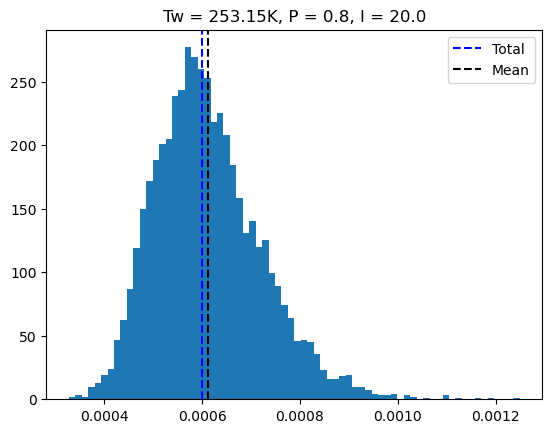

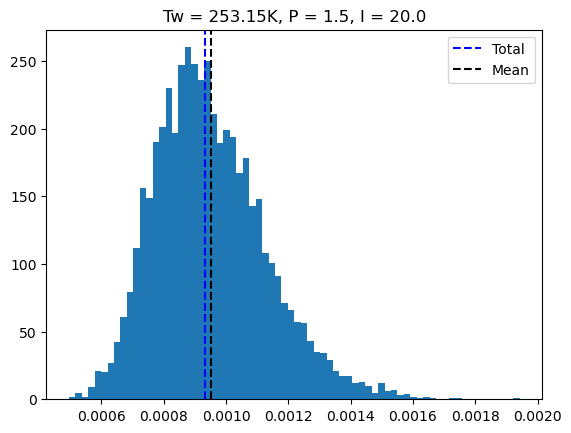

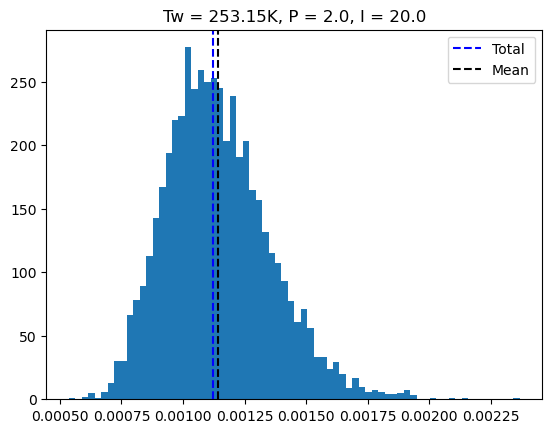

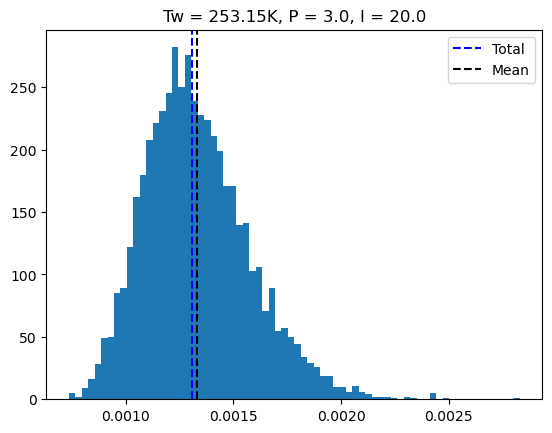

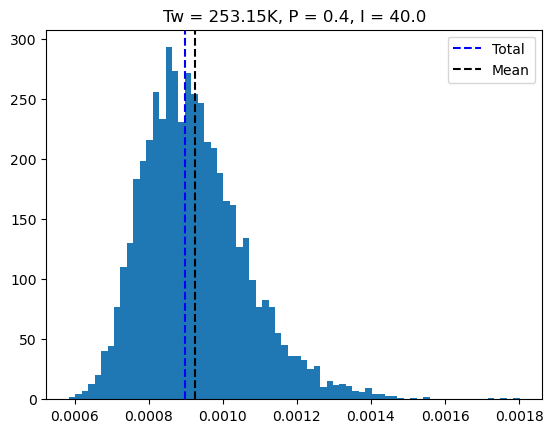

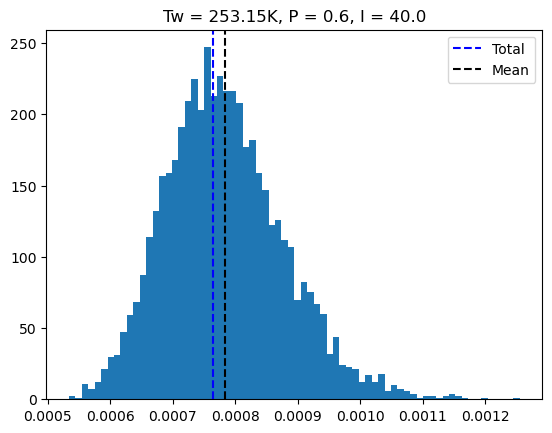

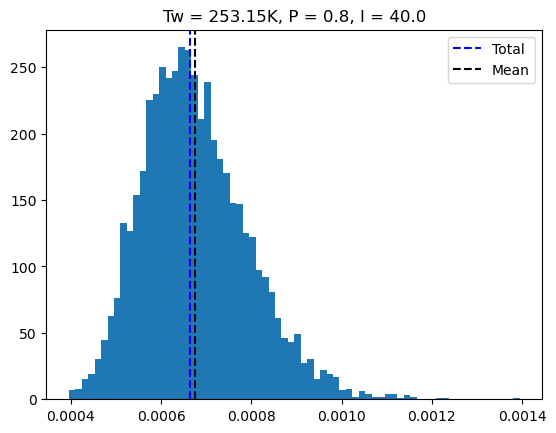

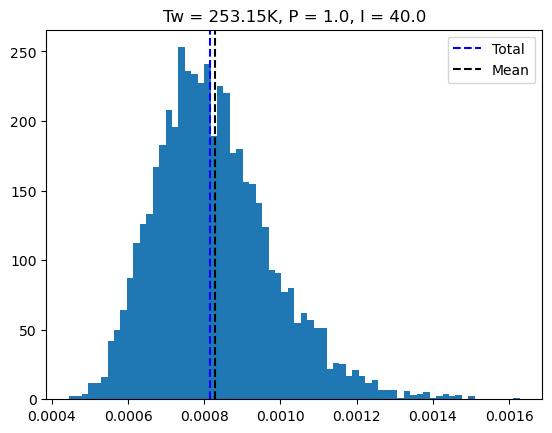

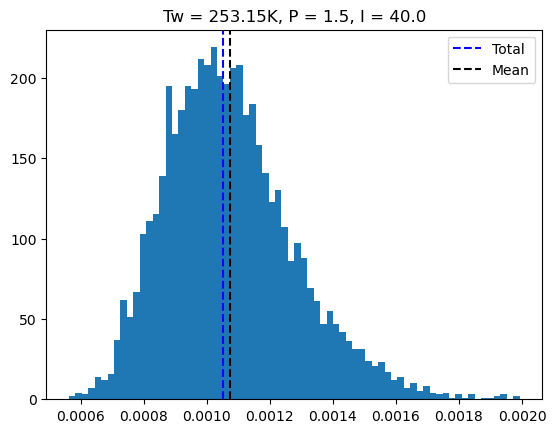

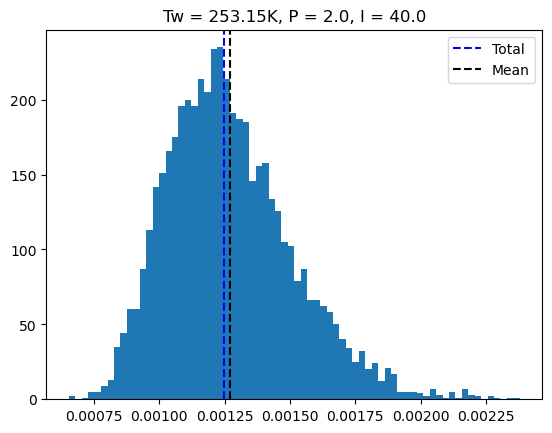

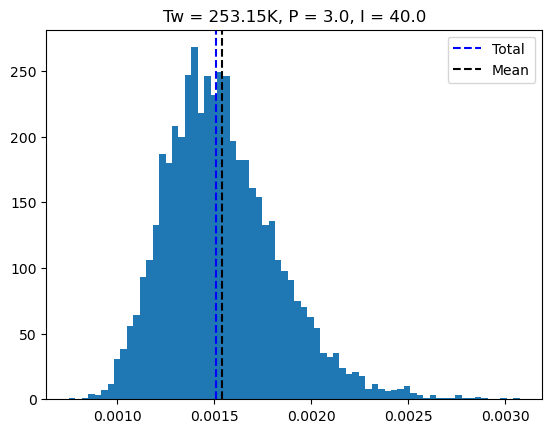

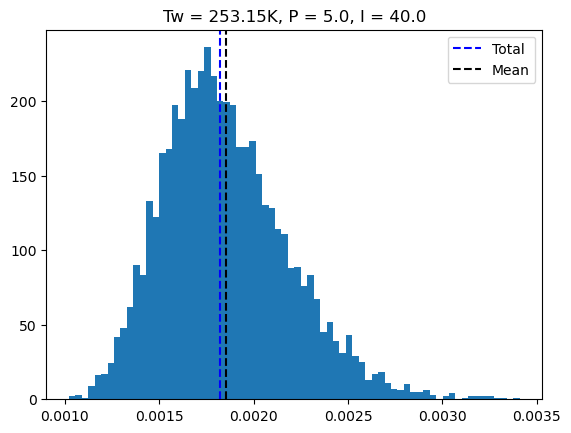

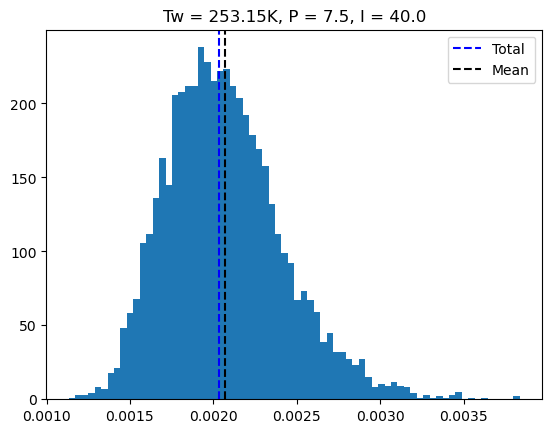

In [9]:
Tw_unique_values = np.unique(Tw_vec)
sum_value = 0

for value in Tw_unique_values:
    Tw = value
    indices = np.where((Tw_vec == Tw))[0]

    if Tw - 273.15 > 0:
        continue
    
    gammas_exp = gammas_exp_vec[indices]
    
    gammas_total_comp = gammas_data[indices]
    gammas_total = np.sum(gammas_total_comp, axis=1)
    
    for index in indices:
        
        plt.figure()
        plt.title(f"Tw = {round(Tw, 2)}K, P = {pressure_vec[index]}, I = {current_vec[index]}")
        plt.hist(data_hist[index], bins=70)
        plt.axvline(x=gammas_total[index], color='blue', linestyle='--', label='Total')
        plt.axvline(x=data_mean[index], color='black', linestyle='--', label='Mean')
        plt.legend()